## UCI data prep

In [1]:
from walmart_ahmedkobtan_agentic_store_operations.src.utils.constants import ROOT_DIR
import pandas as pd
from pathlib import Path

In [2]:
# df = pd.read_excel(Path(ROOT_DIR) / "data" / "raw" / "online_retail_II_2009.xlsx")

In [3]:
# df.groupby(['Invoice','InvoiceDate']).count()

      timestamp_local  demand_count store_id  dow  hour  doy  is_holiday
0 2009-12-01 07:00:00             2     S001    1     7  335           1
1 2009-12-01 08:00:00             0     S001    1     8  335           1
2 2009-12-01 09:00:00            10     S001    1     9  335           1
2009-12-01 07:00:00 → 2011-12-09 12:00:00
Rows: 17718 | Hours covered: 17718


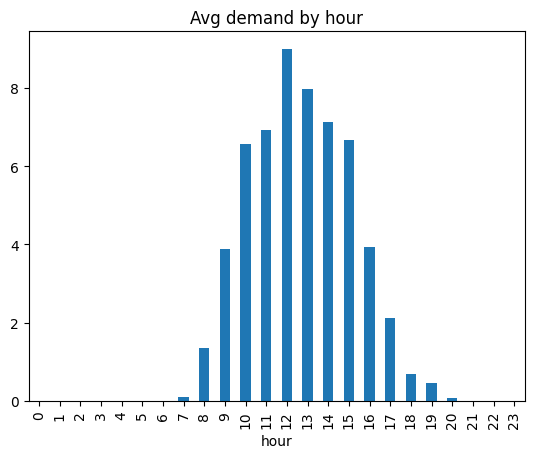

In [4]:
df_hourly = pd.read_parquet(ROOT_DIR / Path("data/processed/hourly_demand.parquet"))
print(df_hourly.head(3))
print(df_hourly["timestamp_local"].min(), "→", df_hourly["timestamp_local"].max())
print("Rows:", len(df_hourly), "| Hours covered:", df_hourly["timestamp_local"].nunique())
ax = df_hourly.groupby("hour")["demand_count"].mean().plot(kind="bar", title="Avg demand by hour")

In [5]:
df_hourly.groupby("hour")["demand_count"].mean().values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.35501355e-03, 1.04194858e-01,
       1.35453315e+00, 3.87821380e+00, 6.55074425e+00, 6.91745602e+00,
       8.99052774e+00, 7.97696477e+00, 7.13685637e+00, 6.65311653e+00,
       3.92547425e+00, 2.10704607e+00, 6.77506775e-01, 4.51219512e-01,
       7.18157182e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [6]:
df_hourly.columns

Index(['timestamp_local', 'demand_count', 'store_id', 'dow', 'hour', 'doy',
       'is_holiday'],
      dtype='object')

## Employee roster

In [6]:
from walmart_ahmedkobtan_agentic_store_operations.src.utils.roster_utils import load_roster, availability_mask_for_day, WEEKDAYS

In [7]:
emps = load_roster(ROOT_DIR / Path("data/roster/employees.csv"))

In [8]:
emp_idx = 2
mask = availability_mask_for_day(emps[emp_idx], weekday_idx=0, open_hour=6, close_hour=21)  # Monday

In [9]:
print(emps[emp_idx], sum(mask), "available hours in window")

Employee(employee_id='E003', role='cashier', base_wage=16.0, availability={'mon': (7, 14), 'tue': (7, 14), 'wed': (7, 14), 'thu': (7, 14), 'fri': (7, 14), 'sat': (None, None), 'sun': (None, None)}) 7 available hours in window


In [10]:
sum([sum(availability_mask_for_day(e, weekday_idx=0, open_hour=6, close_hour=21)) for e in emps])

89

In [9]:
for i in range(7):
    print(f"Weekday {i}: total available employee-hours in window 06-21 = {sum([sum(availability_mask_for_day(e, weekday_idx=i, open_hour=6, close_hour=21)) for e in emps])}")

Weekday 0: total available employee-hours in window 06-21 = 92
Weekday 1: total available employee-hours in window 06-21 = 90
Weekday 2: total available employee-hours in window 06-21 = 92
Weekday 3: total available employee-hours in window 06-21 = 90
Weekday 4: total available employee-hours in window 06-21 = 92
Weekday 5: total available employee-hours in window 06-21 = 93
Weekday 6: total available employee-hours in window 06-21 = 87


## Demand Forecasting

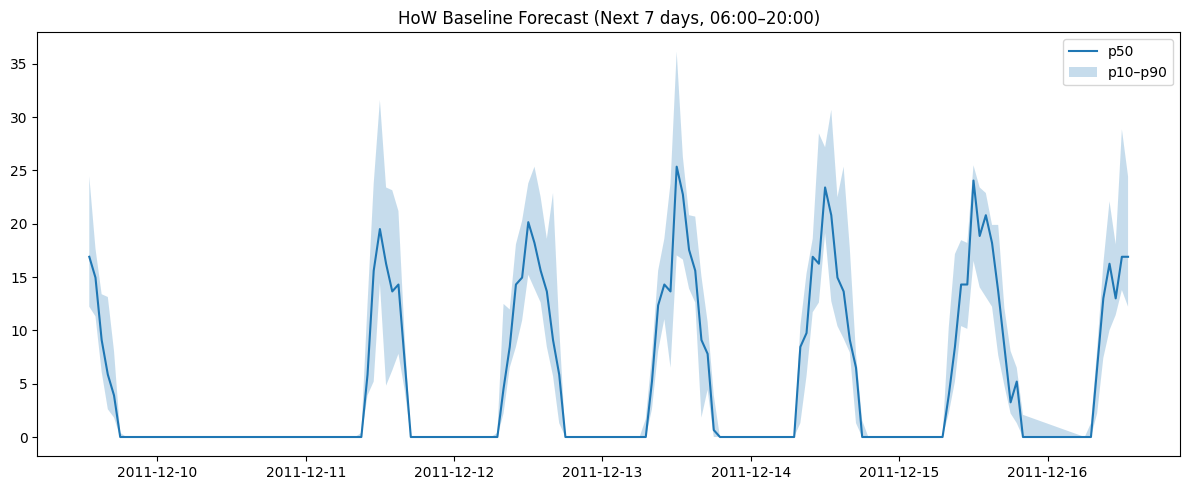

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from walmart_ahmedkobtan_agentic_store_operations.src.utils.constants import DATA_DIR, ARTIFACT_OUT_DIR


hist = pd.read_parquet(DATA_DIR / "processed/hourly_demand.parquet")
fc   = pd.read_parquet(ARTIFACT_OUT_DIR / "df_forecast_next7d_how.parquet")
plt.figure(figsize=(12,5))
plt.plot(fc["timestamp_local"], fc["yhat_p50"], label="p50")
plt.fill_between(fc["timestamp_local"], fc["yhat_p10"], fc["yhat_p90"], alpha=0.25, label="p10–p90")
plt.title("HoW Baseline Forecast (Next 7 days, 06:00–20:00)")
plt.legend(); plt.tight_layout(); plt.show()

In [9]:
fc.to_csv(ARTIFACT_OUT_DIR/'df_forecast_next7d_how.csv', index=False)

In [10]:
fc   = pd.read_parquet(ARTIFACT_OUT_DIR / "df_forecast_next7d_how.parquet")

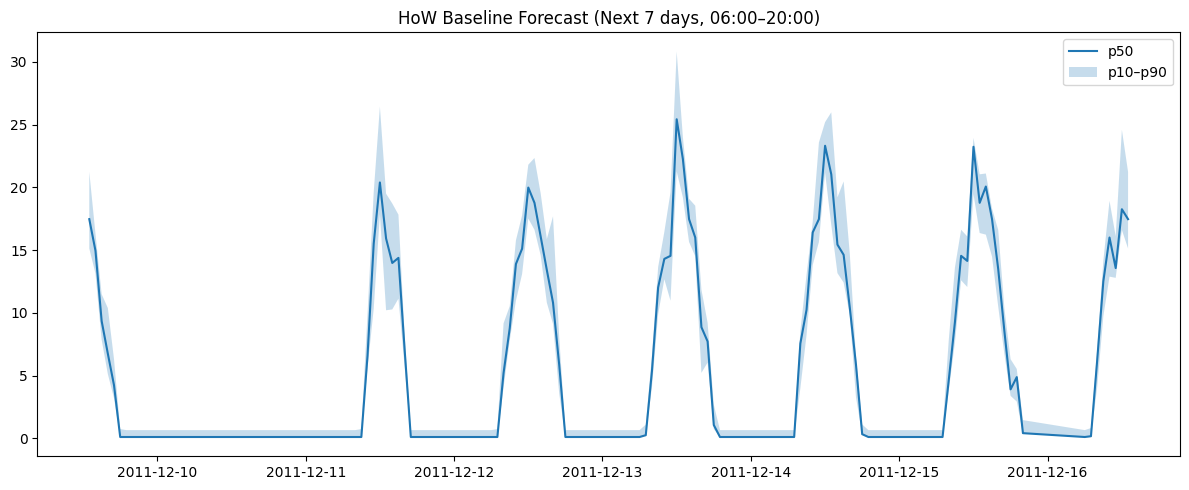

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from walmart_ahmedkobtan_agentic_store_operations.src.utils.constants import DATA_DIR, ARTIFACT_OUT_DIR


hist = pd.read_parquet(DATA_DIR / "processed/hourly_demand.parquet")
fc   = pd.read_parquet(ARTIFACT_OUT_DIR / "df_forecast_next7d_how.parquet")
plt.figure(figsize=(12,5))
plt.plot(fc["timestamp_local"], fc["yhat_p50"], label="p50")
plt.fill_between(fc["timestamp_local"], fc["yhat_p10"], fc["yhat_p90"], alpha=0.25, label="p10–p90")
plt.title("HoW Baseline Forecast (Next 7 days, 06:00–20:00)")
plt.legend(); plt.tight_layout(); plt.show()

In [13]:
fc

,timestamp_local,yhat_p10,yhat_p50,yhat_p90
0,2011-12-09 13:00:00,15.128750,17.468750,21.238750
1,2011-12-09 14:00:00,13.130000,14.950000,16.315000
2,2011-12-09 15:00:00,7.848750,9.343750,11.488750
3,2011-12-09 16:00:00,5.118750,6.743750,10.383750
4,2011-12-09 17:00:00,3.185000,4.225000,6.305000
...,...,...,...,...
101,2011-12-16 09:00:00,9.717500,12.512500,14.137500
102,2011-12-16 10:00:00,12.886250,16.006250,18.931250
103,2011-12-16 11:00:00,12.788750,13.568750,16.103750
104,2011-12-16 12:00:00,16.607712,18.259477,24.591242


In [14]:
fc.to_csv(ARTIFACT_OUT_DIR/'df_forecast_next7d_how.csv', index=False)
hist.to_csv(ARTIFACT_OUT_DIR/'hourly_demand.csv', index=False)

In [33]:
role_targets_df = pd.read_parquet("/Users/auk003i/Documents/Personal_Projects/agentic_store_operations/walmart_ahmedkobtan_agentic_store_operations/data/artifacts/role_targets_next7d.parquet")


In [34]:
role_targets_df

,timestamp_local,lead_needed,cashier_needed,floor_needed
0,2011-12-09 13:00:00,1,2,1
1,2011-12-09 14:00:00,1,1,1
2,2011-12-09 15:00:00,1,1,1
3,2011-12-09 16:00:00,1,1,1
4,2011-12-09 17:00:00,1,0,0
...,...,...,...,...
101,2011-12-16 09:00:00,1,1,1
102,2011-12-16 10:00:00,1,1,1
103,2011-12-16 11:00:00,1,1,1
104,2011-12-16 12:00:00,1,2,1


In [35]:
role_targets_df.to_csv("/Users/auk003i/Documents/Personal_Projects/agentic_store_operations/walmart_ahmedkobtan_agentic_store_operations/data/artifacts/role_targets_next7d.csv", index=False)

In [45]:
proposed_schedule = pd.read_parquet("/Users/auk003i/Documents/Personal_Projects/agentic_store_operations/walmart_ahmedkobtan_agentic_store_operations/data/artifacts/schedule_proposal.parquet")

In [46]:
proposed_schedule

,employee_id,role,day,start_hour,end_hour,length
0,E001,lead,2011-12-09,6,14,8
1,E002,lead,2011-12-09,14,21,7
2,E006,cashier,2011-12-09,13,17,4
3,E012,floor,2011-12-09,13,17,4
4,E001,lead,2011-12-10,11,15,4
5,E002,lead,2011-12-10,15,21,6
6,E017,lead,2011-12-10,6,11,5
7,E001,lead,2011-12-11,11,17,6
8,E002,lead,2011-12-11,17,21,4
9,E005,cashier,2011-12-11,12,17,5


In [47]:
proposed_schedule.to_csv("/Users/auk003i/Documents/Personal_Projects/agentic_store_operations/walmart_ahmedkobtan_agentic_store_operations/data/artifacts/schedule_proposal.csv")

In [ ]:
from walmart_ahmedkobtan_agentic_store_operations.src.algorithms.forecast import fit_baseline_prophet, forecast
from walmart_ahmedkobtan_agentic_store_operations.src.algorithms.backtest import rolling_backtest

/Users/auk003i/Library/Caches/pypoetry/virtualenvs/walmart-ahmedkobtan-agentic-store-operatio-V7OwshHp-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
m = fit_baseline_prophet(df_hourly)


07:49:16 - cmdstanpy - INFO - Chain [1] start processing
07:49:20 - cmdstanpy - INFO - Chain [1] done processing


/Users/auk003i/Documents/Personal_Projects/agentic_store_operations/walmart_ahmedkobtan_agentic_store_operations/src/algorithms/forecast.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future = pd.date_range(last_ts + pd.Timedelta(hours=1),


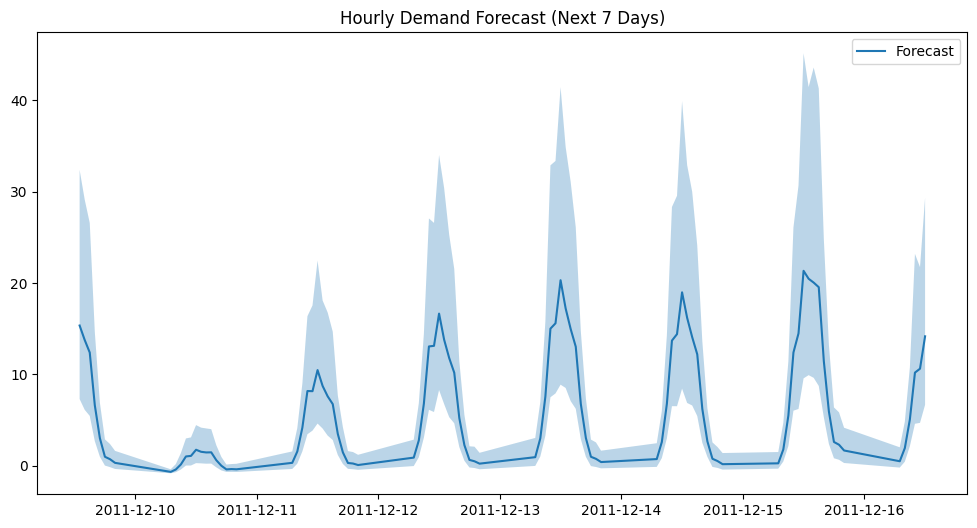

In [14]:
import matplotlib.pyplot as plt
fcst = forecast(df_hourly)
plt.figure(figsize=(12,6))
plt.plot(fcst["timestamp_local"], fcst["yhat_p50"], label="Forecast")
# plt.plot(df_hourly["timestamp_local"], df_hourly["demand_count"], label="Actual", alpha=0.5)
plt.fill_between(fcst["timestamp_local"], fcst["yhat_p10"], fcst["yhat_p90"], alpha=0.3)
plt.title("Hourly Demand Forecast (Next 7 Days)")
plt.legend()
plt.show()

In [21]:
fcst

,timestamp_local,yhat_p10,yhat_p50,yhat_p90
0,2011-12-09 13:00:00,7.283986,15.338318,32.383343
1,2011-12-09 14:00:00,6.109082,13.760195,29.147226
2,2011-12-09 15:00:00,5.438363,12.377290,26.579061
3,2011-12-09 16:00:00,2.672438,6.605055,14.640062
4,2011-12-09 17:00:00,0.967928,3.002640,6.894181
...,...,...,...,...
93,2011-12-16 08:00:00,0.418699,1.909396,4.805435
94,2011-12-16 09:00:00,2.123473,5.061159,10.763208
95,2011-12-16 10:00:00,4.576527,10.181160,23.190230
96,2011-12-16 11:00:00,4.676119,10.609007,21.734719


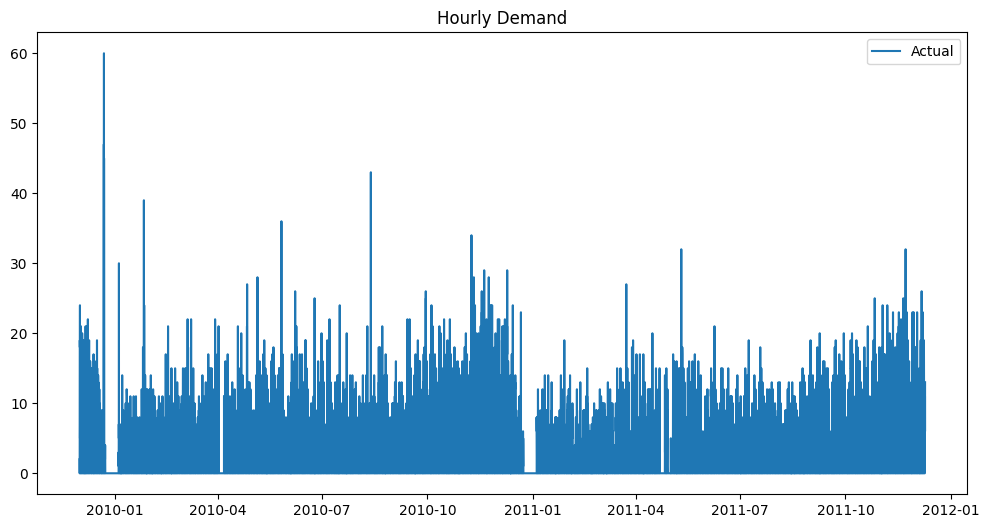

In [15]:
plt.figure(figsize=(12,6))
plt.plot(df_hourly["timestamp_local"], df_hourly["demand_count"], label="Actual")
plt.title("Hourly Demand")
plt.legend()
plt.show()

In [16]:
# plot mape errors
backtest_df = rolling_backtest(df_hourly, train_weeks = 8, test_weeks = 1)


07:49:41 - cmdstanpy - INFO - Chain [1] start processing
07:49:41 - cmdstanpy - INFO - Chain [1] done processing
07:49:41 - cmdstanpy - INFO - Chain [1] start processing
07:49:42 - cmdstanpy - INFO - Chain [1] done processing
07:49:42 - cmdstanpy - INFO - Chain [1] start processing
07:49:42 - cmdstanpy - INFO - Chain [1] done processing
07:49:42 - cmdstanpy - INFO - Chain [1] start processing
07:49:43 - cmdstanpy - INFO - Chain [1] done processing
07:49:43 - cmdstanpy - INFO - Chain [1] start processing
07:49:43 - cmdstanpy - INFO - Chain [1] done processing
07:49:43 - cmdstanpy - INFO - Chain [1] start processing
07:49:44 - cmdstanpy - INFO - Chain [1] done processing
07:49:44 - cmdstanpy - INFO - Chain [1] start processing
07:49:44 - cmdstanpy - INFO - Chain [1] done processing
07:49:44 - cmdstanpy - INFO - Chain [1] start processing
07:49:45 - cmdstanpy - INFO - Chain [1] done processing
07:49:45 - cmdstanpy - INFO - Chain [1] start processing
07:49:45 - cmdstanpy - INFO - Chain [1]

In [17]:
backtest_df

[{'window_start': Timestamp('2010-01-26 07:00:00'),
  'MAPE': np.float64(66.67890562511994),
  'sMAPE': np.float64(121.07159237583079)},
 {'window_start': Timestamp('2010-02-02 07:00:00'),
  'MAPE': np.float64(62.196351573713706),
  'sMAPE': np.float64(109.25259496164847)},
 {'window_start': Timestamp('2010-02-09 07:00:00'),
  'MAPE': np.float64(67.68847404210585),
  'sMAPE': np.float64(116.77214958808018)},
 {'window_start': Timestamp('2010-02-16 07:00:00'),
  'MAPE': np.float64(71.72348481658238),
  'sMAPE': np.float64(122.36543287304525)},
 {'window_start': Timestamp('2010-02-23 07:00:00'),
  'MAPE': np.float64(66.32786203456564),
  'sMAPE': np.float64(114.78844231015508)},
 {'window_start': Timestamp('2010-03-02 07:00:00'),
  'MAPE': np.float64(63.610857702446964),
  'sMAPE': np.float64(113.29568999502997)},
 {'window_start': Timestamp('2010-03-09 07:00:00'),
  'MAPE': np.float64(71.60217748638449),
  'sMAPE': np.float64(115.28789480788136)},
 {'window_start': Timestamp('2010-03-16

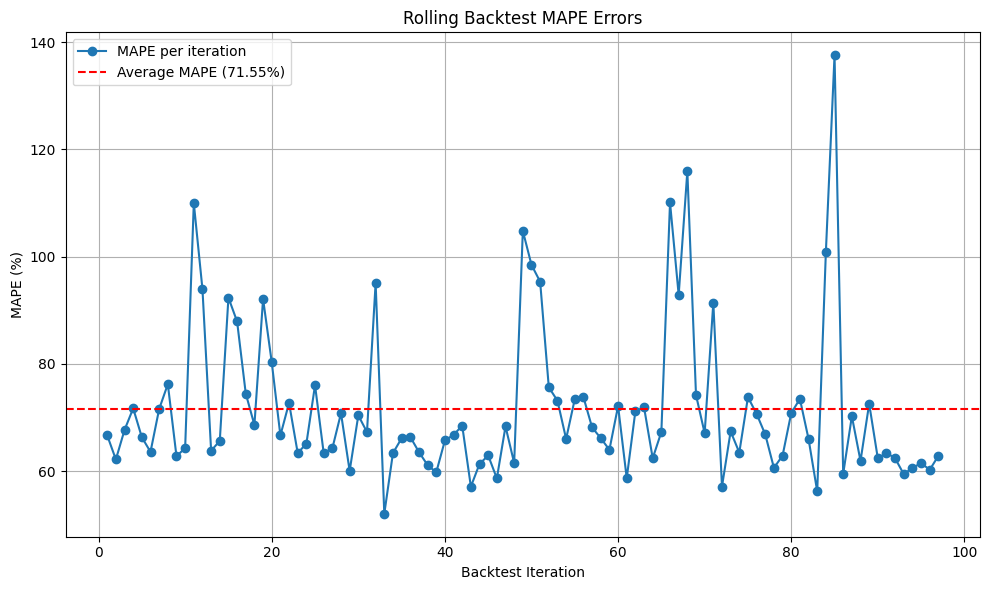

In [19]:

bt_mape = [b['MAPE'] for b in backtest_df]
iterations = range(1, len(bt_mape) + 1)
avg_mape = sum(bt_mape) / len(bt_mape)

plt.figure(figsize=(10, 6))
plt.plot(iterations, bt_mape, marker='o', label='MAPE per iteration')
plt.axhline(avg_mape, color='red', linestyle='--', label=f'Average MAPE ({avg_mape:.2f}%)')

plt.title('Rolling Backtest MAPE Errors')
plt.xlabel('Backtest Iteration')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
avg_mape

np.float64(71.55397282703186)